#  <center> Feature Selection with Null Importance </center>

Notebook: https://www.kaggle.com/code/ogrellier/feature-selection-with-null-importances/notebook

In [45]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pprint
from time import time
from datetime import datetime
from functools import partial

import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings("ignore")

## Import Data

In this notebook, we are use the data from this competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

(I have done some **preprocessing** to clean the data before we use it!)

In [2]:
#import the cleaned training and test data
X_train = pd.read_csv('../input/cleaned-train-x/cleaned_train_X.csv')
y_train = pd.read_csv('../input/cleaned-train-y/cleaned_train_y.csv')

#the raw data can be imported as following
#df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
#df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
print(f'There are in total {len(X_train.columns)} features.')

There are in total 300 features.


In [4]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.067331,-0.209359,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.581145,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,-0.873616,0.481900,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178255,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.067331,-0.071107,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.098189,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.302568,-0.439779,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494529,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.067331,0.666236,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,0.469187,-0.293025,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


## Evaluation

In [81]:
#define the evaluation metric as 5-fold cross-validation root-mean-square-error
def rmsle_cv(model, X_train, y_train):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

## Scoring Function for Feature Importance

In [18]:
def get_feature_importances(X, y, shuffle):

    # get the features
    train_features = list(X.columns)
    
    # Shuffle target if required
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y.sample(frac=1.0)
    
    # fit LightGBM in RF mode, it's quicker than sklearn RandomForest
    reg = lgb.LGBMRegressor(boosting_type = 'gbdt',
                            objective = 'regression',
                            metric = 'rmse',
                            learning_rate = 0.018361862613756427,
                            max_bin = 563,
                            max_depth = 232,
                            min_child_samples = 14,
                            min_child_weight = 9.09418529590311,
                            n_estimators = 1000,
                            num_leaves = 505,
                            reg_alpha = 0.0009168150882046735,
                            reg_lambda = 0.18253962681965613,
                            subsample = 0.6737101592760297,
                            subsample_freq = 10,
                            random_state = 0)
    
    reg.fit(X,y)
    
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = reg.feature_importances_
    imp_df['train_score'] = np.sqrt(mean_squared_error(y, reg.predict(X)))
    
    return imp_df

## Benchmark

In [19]:
np.random.seed(0)
actual_imp_df = get_feature_importances(X_train, y_train,shuffle=False)
actual_imp_df.head()

,feature,importance_gain,train_score
0,MSSubClass,584,0.024691
1,LotFrontage,2413,0.024691
2,LotArea,3824,0.024691
3,OverallQual,1078,0.024691
4,OverallCond,910,0.024691


## Null Importance Distribution

In [26]:
null_imp_df = pd.DataFrame()
n_runs = 80

start = time()

for i in range(n_runs):
    
    # Get current run importances
    imp_df = get_feature_importances(X_train, y_train, shuffle=True)
    imp_df['run'] = i + 1 
    
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    
    # Display current run and time used
    spent = (time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp)

Done with    1 of   80 (Spent   0.1 min)
Done with    2 of   80 (Spent   0.2 min)
Done with    3 of   80 (Spent   0.2 min)
Done with    4 of   80 (Spent   0.3 min)
Done with    5 of   80 (Spent   0.4 min)
Done with    6 of   80 (Spent   0.5 min)
Done with    7 of   80 (Spent   0.6 min)
Done with    8 of   80 (Spent   0.7 min)
Done with    9 of   80 (Spent   0.8 min)
Done with   10 of   80 (Spent   0.8 min)
Done with   11 of   80 (Spent   0.9 min)
Done with   12 of   80 (Spent   1.0 min)
Done with   13 of   80 (Spent   1.1 min)
Done with   14 of   80 (Spent   1.2 min)
Done with   15 of   80 (Spent   1.3 min)
Done with   16 of   80 (Spent   1.3 min)
Done with   17 of   80 (Spent   1.4 min)
Done with   18 of   80 (Spent   1.5 min)
Done with   19 of   80 (Spent   1.6 min)
Done with   20 of   80 (Spent   1.7 min)
Done with   21 of   80 (Spent   1.8 min)
Done with   22 of   80 (Spent   1.9 min)
Done with   23 of   80 (Spent   2.0 min)
Done with   24 of   80 (Spent   2.1 min)
Done with   25 o

## Plot Distributions

In [38]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13,6))
    ax = plt.subplot(1,1,1)
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

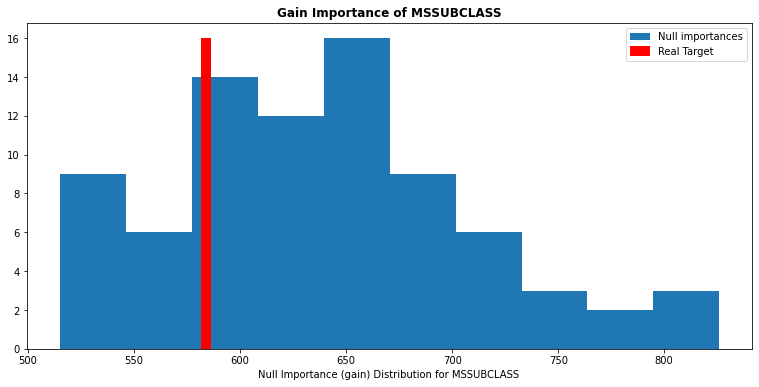

In [49]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='MSSubClass')

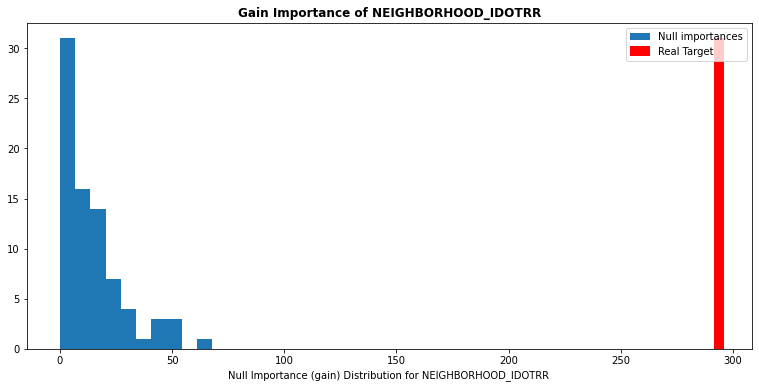

In [47]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Neighborhood_IDOTRR')

## Plot Feature Importance

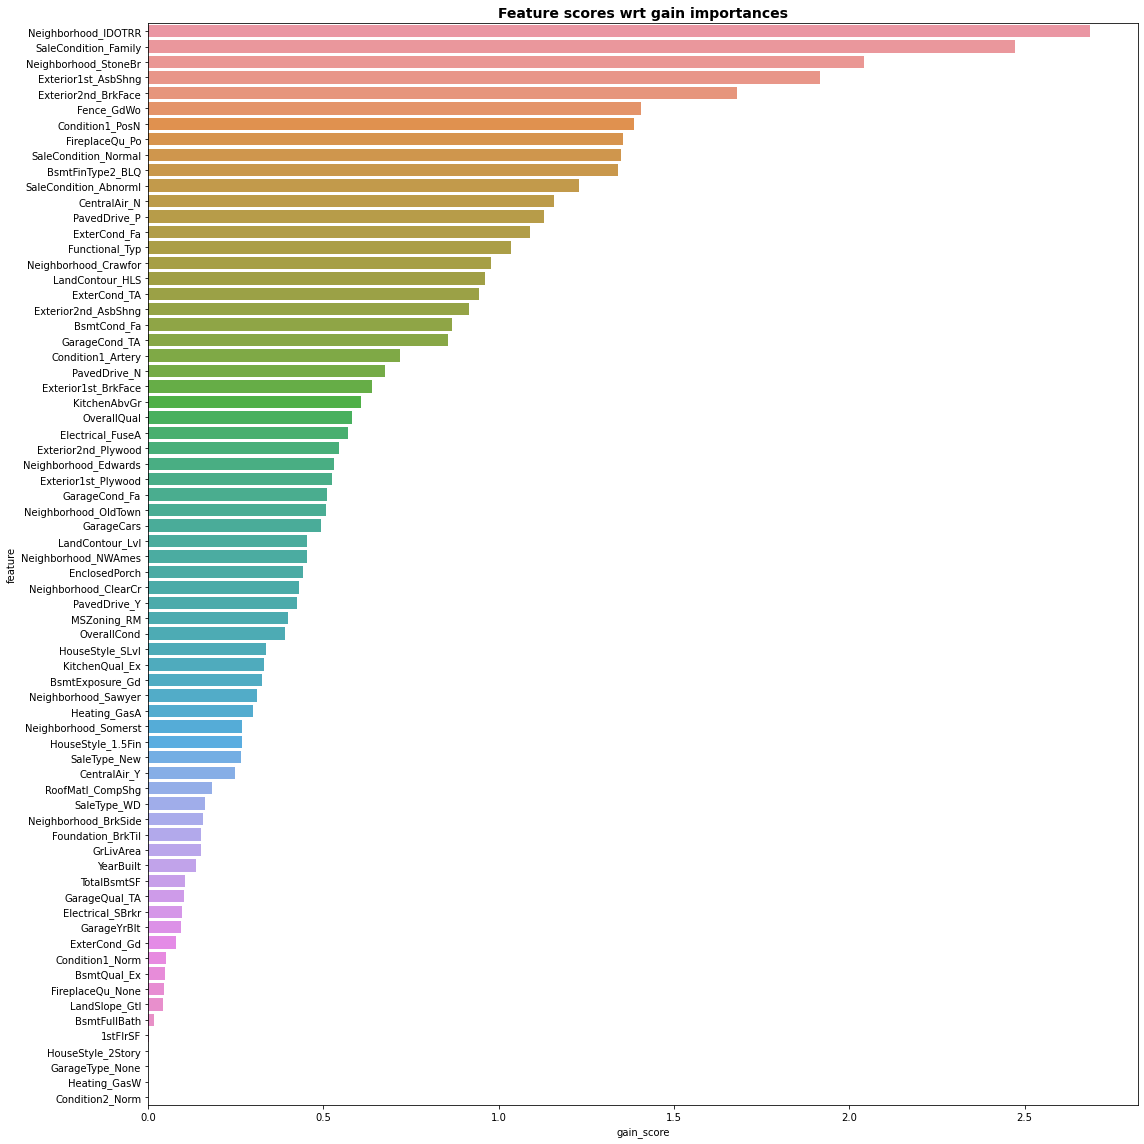

In [46]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75))) 
    feature_scores.append((_f, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'gain_score'])

plt.figure(figsize=(16, 16))
# Plot Gain importances
ax = plt.subplot(1,1,1)
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [54]:
scores_df = scores_df.sort_values(by='gain_score', ascending=False)
scores_df.head()

,feature,gain_score
71,Neighborhood_IDOTRR,2.687847
297,SaleCondition_Family,2.473346
84,Neighborhood_StoneBr,2.040975
131,Exterior1st_AsbShng,1.916923
149,Exterior2nd_BrkFace,1.679281


## Scoring Features

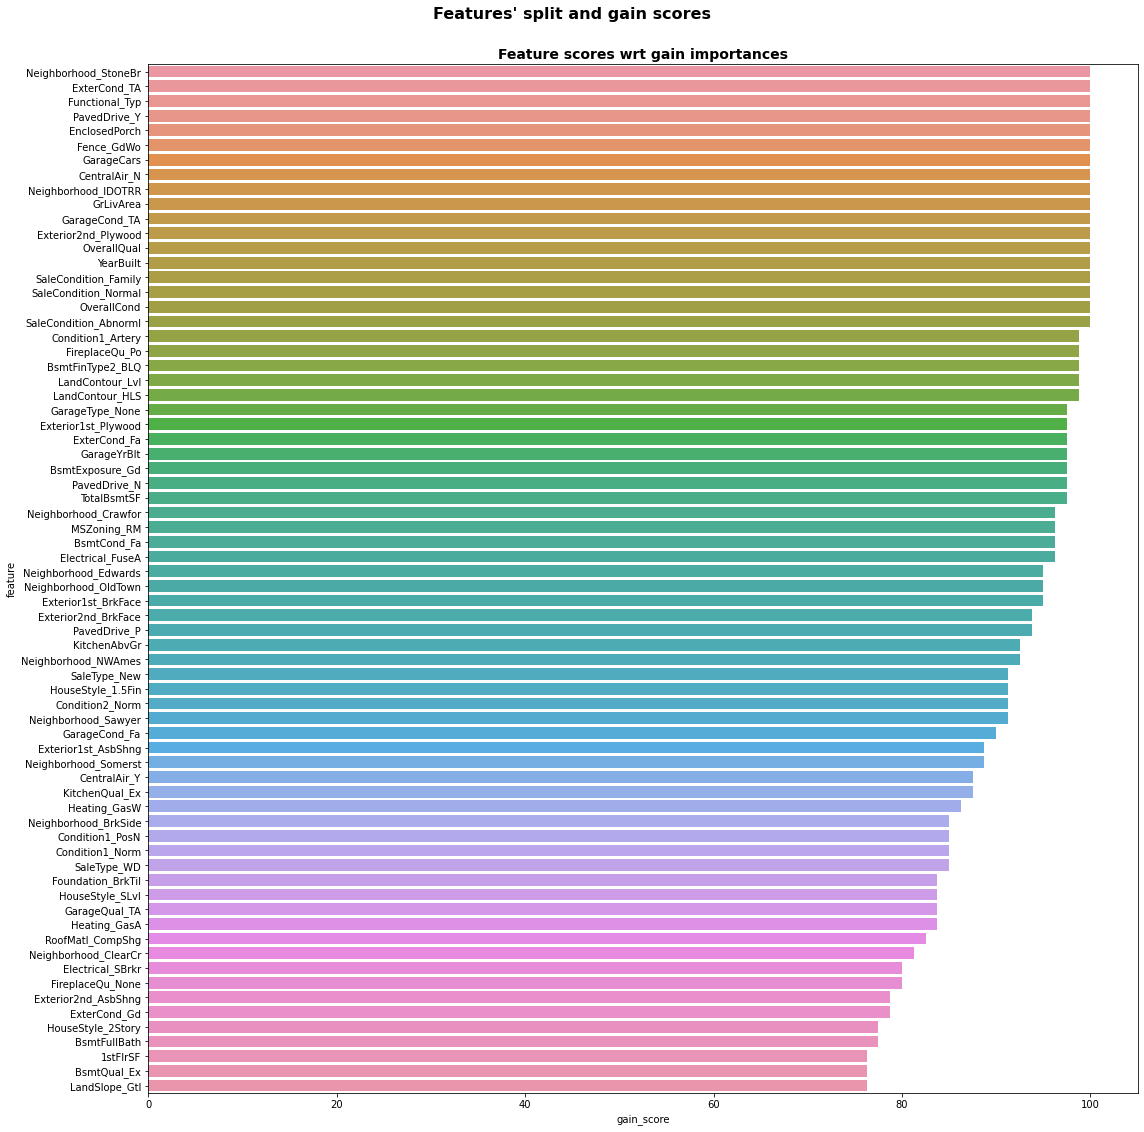

In [73]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, gain_score))
    
corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
# Plot Gain importances
ax = plt.subplot(1,1,1)
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [74]:
corr_scores_df = corr_scores_df.sort_values(by='gain_score', ascending=False
corr_scores_df.head()

,feature,gain_score
84,Neighborhood_StoneBr,100.0
174,ExterCond_TA,100.0
238,Functional_Typ,100.0
270,PavedDrive_Y,100.0
29,EnclosedPorch,100.0


## Feature Selection

In [79]:
top_100_features = corr_scores_df['feature'][:100]
top_100_features

84     Neighborhood_StoneBr
174            ExterCond_TA
238          Functional_Typ
270            PavedDrive_Y
29            EnclosedPorch
               ...         
139     Exterior1st_MetalSd
161     Exterior2nd_Wd Shng
31              ScreenPorch
217            HeatingQC_Fa
111       HouseStyle_1Story
Name: feature, Length: 100, dtype: object

## Evaluation

In [80]:
reg = lgb.LGBMRegressor(boosting_type = 'gbdt',
                        objective = 'regression',
                        metric = 'rmse',
                        learning_rate = 0.018361862613756427,
                        max_bin = 563,
                        max_depth = 232,
                        min_child_samples = 14,
                        min_child_weight = 9.09418529590311,
                        n_estimators = 1000,
                        num_leaves = 505,
                        reg_alpha = 0.0009168150882046735,
                        reg_lambda = 0.18253962681965613,
                        subsample = 0.6737101592760297,
                        subsample_freq = 10,
                        random_state = 0)

In [84]:
print('5-Flod Cross-Validation score: (smaller the better):\n')

lgb_score = rmsle_cv(reg, X_train, y_train)
print(f"All features = {round(lgb_score.mean(),3)} ({round(lgb_score.std(),3)})")

lgb_best_score = rmsle_cv(reg, X_train[top_100_features], y_train)
print(f"Top 100 features = {round(lgb_best_score.mean(),3)} ({round(lgb_best_score.std(),3)})")

5-Flod Cross-Validation score: (smaller the better):

All features = 0.132 (0.009)
Top 100 features = 0.13 (0.009)
